# Automated Annotation Workflow

This workflow uses the auto_annot tools from besca to newly annotate a scRNAseq dataset based on one or more preannotated datasets. Ideally, these datasets come from a similar tissue and condition.

We use supervised machine learning methods to annotate each individual cell utilizing methods like support vector machines (SVM) or logistic regression.

First, the traning dataset(s) and the testing dataset are loaded from h5ad files or made available as adata objects. Next, the training and testing datasets are corrected using scanorama, and the training datasets are then merged into one anndata object. Then, the classifier is trained utilizing the merged training data. Finally, the classifier is applied to the testing dataset to predict the cell types. If the testing dataset is already annotated (to test the algorithm), a report including confusion matrices can be generated.

In [1]:
import besca as bc

/home/luis/anaconda3/envs/bescafinal/lib/python3.8/site-packages/scanpy/api/__init__.py:3: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  warnings.warn(


In [2]:
import scanpy as sc

### test load datasets with scvelo

Apparently the scv loader makes sure the adata objects are all in comparable format whereas the sc loader loads them as is.

In [16]:
adata_test = bc.datasets.pbmc3k_processed()

In [4]:
adata_test_orig = bc.datasets.pbmc3k_processed()

In [5]:
adata_test.obs.dblabel.unique()

[naive thymus-derived CD8-positive, alpha-beta ..., naive B cell, central memory CD4-positive, alpha-beta T cell, classical monocyte, IL7R-max CD8-positive, alpha-beta cytotoxic T ..., non-classical monocyte, naive thymus-derived CD4-positive, alpha-beta ..., CD8-positive, alpha-beta cytotoxic T cell, cytotoxic CD56-dim natural killer cell, CD1c-positive myeloid dendritic cell]
Categories (10, object): [naive thymus-derived CD8-positive, alpha-beta ..., naive B cell, central memory CD4-positive, alpha-beta T cell, classical monocyte, ..., naive thymus-derived CD4-positive, alpha-beta ..., CD8-positive, alpha-beta cytotoxic T cell, cytotoxic CD56-dim natural killer cell, CD1c-positive myeloid dendritic cell]

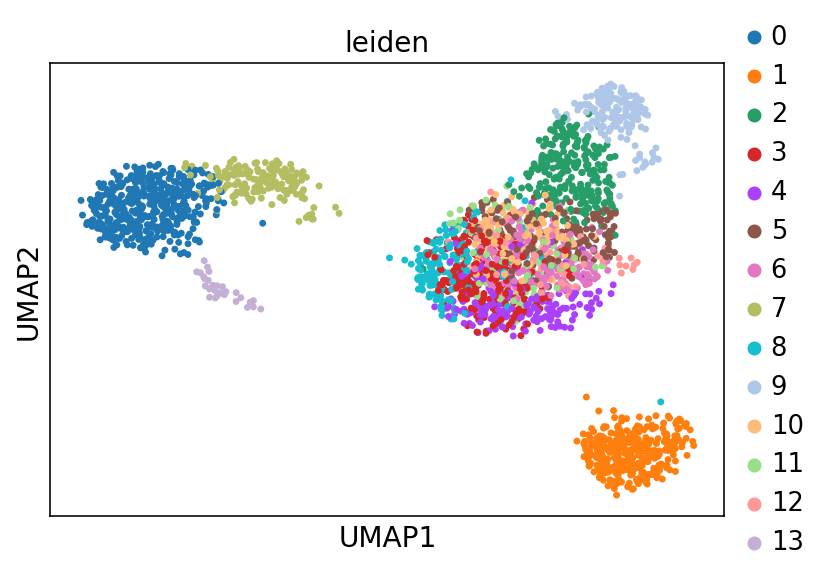

In [19]:
%matplotlib inline

sc.pl.umap(adata_test, color= 'leiden')

In [7]:
#adata_test = scv.read('pbmc3k_processed(1).h5ad')

In [8]:
#adata_test_orig  = scv.read('pbmc3k_processed(1).h5ad')

In [9]:
adata_train1 = bc.datasets.Granja2019_processed()

In [10]:
adata_train2 = bc.datasets.Kotliarov2020_processed()

Concatenation does not lead to errors when the Zenodo loader is used.

In [11]:
train001 = adata_train1.concatenate(adata_train2)

In [12]:
adata_train_list = [adata_train1, adata_train2]

need to rename column for classifier to find annotation

In [13]:
adata_train_list[1].obs["dblabel"] = adata_train_list[1].obs.celltype3

## Parameter specification

Give your analysis a name.

In [3]:
analysis_name = 'auto_annot_pubimage_16072020' # The analysis name will be used to name the output files

Specify column name of celltype annotation you want to train on.

In [4]:
celltype ='dblabel' # This needs to be a column in the .obs of the training datasets (and test dataset if you want to generate a report)

Choose a method:

- linear: Support Vector Machine with Linear Kernel
- sgd: Support Vector Machine with Linear Kernel using Stochastic Gradient Descent
- rbf: Support Vector Machine with radial basis function kernel. Very time intensive, use only on small datasets.
- logistic_regression: Standard logistic classifier iwth multinomial loss.
- logistic_regression_ovr: Logistic Regression with one versus rest classification.
- logistic_regression_elastic: Logistic Regression with elastic loss, cross validates among multiple l1 ratios.

In [5]:
method = 'logistic_regression'

Specify merge method. Needs to be either scanorama or naive.

In [6]:
merge = 'scanorama' # We recommend to use scanorama here

Decide if you want to use the raw format or highly variable genes. Raw increases computational time and does not necessarily improve predictions.

In [7]:
use_raw = False # We recommend to use False here

You can choose to only consider a subset of genes from a signature set or use all genes.

In [8]:
genes_to_use = 'all' # We suggest to use all here, but the runtime is strongly improved if you select an appropriate gene set

In [20]:
adata_test.obs.dblabel.unique()

[naive thymus-derived CD8-positive, alpha-beta ..., naive B cell, central memory CD4-positive, alpha-beta T cell, classical monocyte, IL7R-max CD8-positive, alpha-beta cytotoxic T ..., non-classical monocyte, naive thymus-derived CD4-positive, alpha-beta ..., CD8-positive, alpha-beta cytotoxic T cell, cytotoxic CD56-dim natural killer cell, CD1c-positive myeloid dendritic cell]
Categories (10, object): [naive thymus-derived CD8-positive, alpha-beta ..., naive B cell, central memory CD4-positive, alpha-beta T cell, classical monocyte, ..., naive thymus-derived CD4-positive, alpha-beta ..., CD8-positive, alpha-beta cytotoxic T cell, cytotoxic CD56-dim natural killer cell, CD1c-positive myeloid dendritic cell]

In [21]:
adata_train_list[0].obs.dblabel.unique()

[naive thymus-derived CD4-positive, alpha-beta ..., classical monocyte, naive B cell, lymphocyte of B lineage, naive thymus-derived CD8-positive, alpha-beta ..., ..., IL7R-max CD8-positive, alpha-beta cytotoxic T ..., hematopoietic multipotent progenitor cell, myeloid leukocyte, basophil, plasma cell]
Length: 25
Categories (25, object): [naive thymus-derived CD4-positive, alpha-beta ..., classical monocyte, naive B cell, lymphocyte of B lineage, ..., hematopoietic multipotent progenitor cell, myeloid leukocyte, basophil, plasma cell]

In [22]:
adata_train_list[1].obs.head(10)

CELL  \
10X_CiteSeq_donor256.AAACCTGAGAGCCCAA-1  10X_CiteSeq_donor256.AAACCTGAGAGCCCAA-1   
10X_CiteSeq_donor273.AAACCTGAGGCGTACA-1  10X_CiteSeq_donor273.AAACCTGAGGCGTACA-1   
10X_CiteSeq_donor256.AAACCTGCAGGTGGAT-1  10X_CiteSeq_donor256.AAACCTGCAGGTGGAT-1   
10X_CiteSeq_donor200.AAACCTGCAGTATCTG-1  10X_CiteSeq_donor200.AAACCTGCAGTATCTG-1   
10X_CiteSeq_donor233.AAACCTGCATCACAAC-1  10X_CiteSeq_donor233.AAACCTGCATCACAAC-1   
10X_CiteSeq_donor256.AAACCTGCATGGTCAT-1  10X_CiteSeq_donor256.AAACCTGCATGGTCAT-1   
10X_CiteSeq_donor200.AAACCTGGTTACCAGT-1  10X_CiteSeq_donor200.AAACCTGGTTACCAGT-1   
10X_CiteSeq_donor245.AAACCTGGTTCGGGCT-1  10X_CiteSeq_donor245.AAACCTGGTTCGGGCT-1   
10X_CiteSeq_donor212.AAACCTGTCAAAGTAG-1  10X_CiteSeq_donor212.AAACCTGTCAAAGTAG-1   
10X_CiteSeq_donor245.AAACGGGAGGAGTAGA-1  10X_CiteSeq_donor245.AAACGGGAGGAGTAGA-1   

                                            CONDITION sample_type     donor  \
10X_CiteSeq_donor256.AAACCTGAGAGCCCAA-1  PBMC_healthy        PBMC  donor256   
10X_CiteSeq_donor273.AAACCTGAGGCGTACA-1  PBMC_healthy        PBMC  donor273   
10X_CiteSeq_donor256.AAACCTGCAGGTGGAT-1  PBMC_healthy        PBMC  donor256   
10X_CiteSeq_donor200.AAACCTGCAGTATCTG-1  PBMC_healthy        PBMC  donor200   
10X_CiteSeq_donor233.AAACCTGCATCACAAC-1  PBMC_healthy        PBMC  donor233   
10X_CiteSeq_donor256.AAACCTGCATGGTCAT-1  PBMC_healthy        PBMC  donor256   
10X_CiteSeq_donor200.AAACCTGGTTACCAGT-1  PBMC_healthy        PBMC  donor200   
10X_CiteSeq_donor245.AAACCTGGTTCGGGCT-1  PBMC_healthy        PBMC  donor245   
10X_CiteSeq_donor212.AAACCTGTCAAAGTAG-1  PBMC_healthy        PBMC  donor212   
10X_CiteSeq_donor245.AAACGGGAGGAGTAGA-1  PBMC_healthy        PBMC  donor245   

                                        tenx_lane cohort  batch  sampleid  \
10X_CiteSeq_donor256.AAACCTGAGAGCCCAA-1   H1B1ln1   H1N1      1       256   
10X_CiteSeq_donor273.AAACCTGAGGCGTACA-1   H1B1ln1   H1N1      1       273   
10X_CiteSeq_donor256.AAACCTGCAGGTGGAT-1   H1B1ln1   H1N1      1       256   
10X_CiteSeq_donor200.AAACCTGCAGTATCTG-1   H1B1ln1   H1N1      1       200   
10X_CiteSeq_donor233.AAACCTGCATCACAAC-1   H1B1ln1   H1N1      1       233   
10X_CiteSeq_donor256.AAACCTGCATGGTCAT-1   H1B1ln1   H1N1      1       256   
10X_CiteSeq_donor200.AAACCTGGTTACCAGT-1   H1B1ln1   H1N1      1       200   
10X_CiteSeq_donor245.AAACCTGGTTCGGGCT-1   H1B1ln1   H1N1      1       245   
10X_CiteSeq_donor212.AAACCTGTCAAAGTAG-1   H1B1ln1   H1N1      1       212   
10X_CiteSeq_donor245.AAACGGGAGGAGTAGA-1   H1B1ln1   H1N1      1       245   

                                        timepoint  percent_mito  ...  n_genes  \
10X_CiteSeq_donor256.AAACCTGAGAGCCCAA-1        d0      0.041481  ...      723   
10X_CiteSeq_donor273.AAACCTGAGGCGTACA-1        d0      0.049020  ...      776   
10X_CiteSeq_donor256.AAACCTGCAGGTGGAT-1        d0      0.017332  ...      673   
10X_CiteSeq_donor200.AAACCTGCAGTATCTG-1        d0      0.017222  ...      595   
10X_CiteSeq_donor233.AAACCTGCATCACAAC-1        d0      0.033969  ...      707   
10X_CiteSeq_donor256.AAACCTGCATGGTCAT-1        d0      0.041858  ...      837   
10X_CiteSeq_donor200.AAACCTGGTTACCAGT-1        d0      0.040140  ...      700   
10X_CiteSeq_donor245.AAACCTGGTTCGGGCT-1        d0      0.041958  ...      679   
10X_CiteSeq_donor212.AAACCTGTCAAAGTAG-1        d0      0.023295  ...      790   
10X_CiteSeq_donor245.AAACGGGAGGAGTAGA-1        d0      0.020854  ...      921   

                                         leiden protein_leiden leiden_r1.0  \
10X_CiteSeq_donor256.AAACCTGAGAGCCCAA-1       3              4           6   
10X_CiteSeq_donor273.AAACCTGAGGCGTACA-1       5              3           7   
10X_CiteSeq_donor256.AAACCTGCAGGTGGAT-1       0              0           0   
10X_CiteSeq_donor200.AAACCTGCAGTATCTG-1       0              0           0   
10X_CiteSeq_donor233.AAACCTGCATCACAAC-1       1              2           2   
10X_CiteSeq_donor256.AAACCTGCATGGTCAT-1       1              2           

In [23]:
adata_test.var.dtypes

ENSEMBL           object
SYMBOL          category
n_cells            int64
total_counts     float32
frac_reads       float32
mean             float64
std              float64
dtype: object

In [24]:
adata_train_list[0].var.dtypes

ENSEMBL           object
SYMBOL            object
feature_type    category
n_cells            int64
total_counts     float32
frac_reads       float32
dtype: object

In [25]:
adata_train_list[1].var.dtypes

ENSEMBL         category
SYMBOL            object
feature_type    category
n_cells          float64
total_counts     float32
frac_reads       float32
dtype: object

## Correct datasets (e.g. using scanorama) and merge training datasets

This function merges training datasets, removes unwanted genes, and if scanorama is used corrects for datasets.

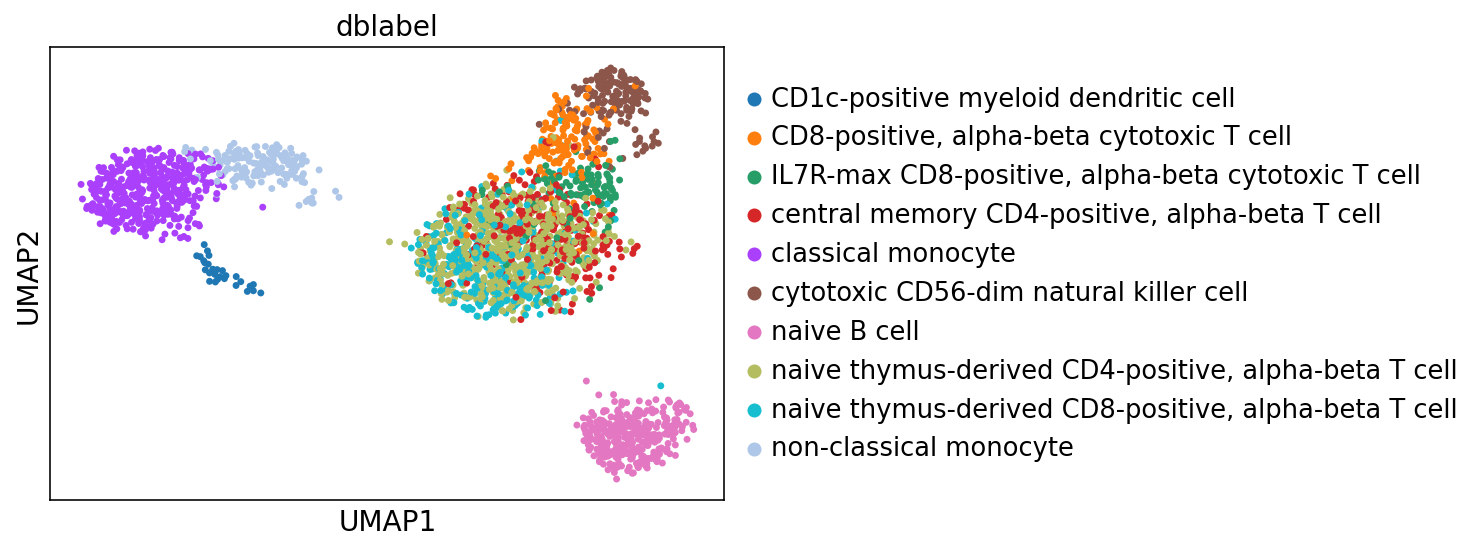

In [21]:
sc.pl.umap(adata_test, color = "dblabel")

In [27]:
adata_train, adata_test_corrected = bc.tl.auto_annot.merge_data(adata_train_list, adata_test, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 207 genes among all datasets
[[0.         0.69557349 0.47404153]
 [0.         0.         0.99201278]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)
integrating training set


In [28]:
adata_train.obs.head(10)

Group  nUMI_pre    nUMI  \
BMMC_10x_GREENLEAF_REP1:AAACCCAAGATGCAGC-1-0  BMMC_D1T1    3982.0  2433.0   
BMMC_10x_GREENLEAF_REP1:AAACCCACAAACTCGT-1-0  BMMC_D1T1    6530.0  5106.0   
BMMC_10x_GREENLEAF_REP1:AAACCCACAGTGTACT-1-0  BMMC_D1T1    4435.0  3589.0   
BMMC_10x_GREENLEAF_REP1:AAACCCATCGCTATTT-1-0  BMMC_D1T1    5119.0  3603.0   
BMMC_10x_GREENLEAF_REP1:AAACGAACACCCAATA-1-0  BMMC_D1T1    2748.0  2065.0   
BMMC_10x_GREENLEAF_REP1:AAACGAACAGCAGTCC-1-0  BMMC_D1T1    4499.0  2783.0   
BMMC_10x_GREENLEAF_REP1:AAACGAACATGACGAG-1-0  BMMC_D1T1    3686.0  1899.0   
BMMC_10x_GREENLEAF_REP1:AAACGAATCAAGCCAT-1-0  BMMC_D1T1    4342.0  2654.0   
BMMC_10x_GREENLEAF_REP1:AAACGCTAGCCGTAAG-1-0  BMMC_D1T1    4396.0  2453.0   
BMMC_10x_GREENLEAF_REP1:AAACGCTAGCTAAACA-1-0  BMMC_D1T1    3946.0  3224.0   

                                               nGene initialClusters  \
BMMC_10x_GREENLEAF_REP1:AAACCCAAGATGCAGC-1-0  1352.0       Cluster20   
BMMC_10x_GREENLEAF_REP1:AAACCCACAAACTCGT-1-0  2001.0       Cluster17   
BMMC_10x_GREENLEAF_REP1:AAACCCACAGTGTACT-1-0  1441.0       Cluster17   
BMMC_10x_GREENLEAF_REP1:AAACCCATCGCTATTT-1-0  1809.0       Cluster31   
BMMC_10x_GREENLEAF_REP1:AAACGAACACCCAATA-1-0  1106.0        Cluster5   
BMMC_10x_GREENLEAF_REP1:AAACGAACAGCAGTCC-1-0  1380.0       Cluster20   
BMMC_10x_GREENLEAF_REP1:AAACGAACATGACGAG-1-0   993.0       Cluster22   
BMMC_10x_GREENLEAF_REP1:AAACGAATCAAGCCAT-1-0  1416.0       Cluster26   
BMMC_10x_GREENLEAF_REP1:AAACGCTAGCCGTAAG-1-0  1277.0       Cluster26   
BMMC_10x_GREENLEAF_REP1:AAACGCTAGCTAAACA-1-0  1411.0       Cluster17   

                                                 UMAP1      UMAP2   Clusters  \
BMMC_10x_GREENLEAF_REP1:AAACCCAAGATGCAGC-1-0  6.333280  -1.546073  Cluster22   
BMMC_10x_GREENLEAF_REP1:AAACCCACAAACTCGT-1-0 -6.626036  -5.624946  Cluster11   
BMMC_10x_GREENLEAF_REP1:AAACCCACAGTGTACT-1-0 -7.221331  -5.927391  Cluster11   
BMMC_10x_GREENLEAF_REP1:AAACCCATCGCTATTT-1-0 -0.538453  12.052552  Cluster16   
BMMC_10x_GREENLEAF_REP1:AAACGAACACCCAATA-1-0 -3.617507   8.777384  Cluster15   
BMMC_10x_GREENLEAF_REP1:AAACGAACAGCAGTCC-1-0  6.813179  -0.441707  Cluster22   
BMMC_10x_GREENLEAF_REP1:AAACGAACATGACGAG-1-0  5.044109  -9.500265  Cluster19   
BMMC_10x_GREENLEAF_REP1:AAACGAATCAAGCCAT-1-0  6.526994  -3.736392  Cluster20   
BMMC_10x_GREENLEAF_REP1:AAACGCTAGCCGTAAG-1-0  5.864159  -3.088735  Cluster20   
BMMC_10x_GREENLEAF_REP1:AAACGCTAGCTAAACA-1-0 -6.669346  -9.584535  Cluster11   

                                             BioClassification  \
BMMC_10x_GREENLEAF_REP1:AAACCCAAGATGCAGC-1-0          22_CD4.M   
BMMC_10x_GREENLEAF_REP1:AAACCCACAAACTCGT-1-0    11_CD14.Mono.1   
BMMC_10x_GREENLEAF_REP1:AAACCCACAGTGTACT-1-0    11_CD14.Mono.1   
BMMC_10x_GREENLEAF_REP1:AAACCCATCGCTATTT-1-0          16_Pre.B   
BMMC_10x_GREENLEAF_REP1:AAACGAACACCCAATA-1-0          15_CLP.2   
BMMC_10x_GREENLEAF_REP1:AAACGAACAGCAGTCC-1-0          22_CD4.M   
BMMC_10x_GREENLEAF_REP1:AAACGAACATGACGAG-1-0          19_CD8.N   
BMMC_10x_GREENLEAF_REP1:AAACGAATCAAGCCAT-1-0         20_CD4.N1   
BMMC_10x_GREENLEAF_REP1:AAACGCTAGCCGTAAG-1-0         20_CD4.N1   
BMMC_10x_GREENLEAF_REP1:AAACGCTAGCTAAACA-1-0    11_CD14.Mono.1   

                                                         Barcode  ...  \
BMMC_10x_GREENLEAF_REP1:AAACCCAAGATGCAGC-1-0  AAACCCAAGATGCAGC-1  ...   
BMMC_10x_GREENLEAF_REP1:AAACCCACAAACTCGT-1-0  AAACCCACAAACTCGT-1  ...   
BMMC_10x_GREENLEAF_REP1:AAACCCACAGTGTACT-1-0  AAACCCACAGTGTACT-1  ...   
BMMC_10x_GREENLEAF_REP1:AAACCCATCGCTATTT-1-0  AAACCCATCGCTATTT-1  ...   
BMMC_10x_GREENLEAF_REP1:AAACGAACACCCAATA-1-0  AAACGAACACCCAATA-1  ...   
BMMC_10x_GREENLEAF_REP1:AAACGAACAGCAGTCC-1-0  AAACGAACAGCAGTCC-1  ...   
BMMC_10x_GREENLEAF_REP1:AAACGAACATGACGAG-1-0  AAACGAACATGACGAG-1  ...   
BMMC_10x_GREENLEAF_REP1:AAACGAATCAAGCCAT-1-0  AAACGAATCAAGCCAT-1  ...   
BMMC_10x_GREENLEAF_REP1:AAACGCTAGCCGTAAG-1-0  AAACGCTAGCCGTAAG-1  ...   
BMMC_10x_GREENLEAF_REP1:AAACGCTAGCTAAACA-1-0  AAACGCTAGCTAAACA-1  ...  

## Train the classifier

The returned scaler is fitted on the training dataset (to zero mean and scaled to unit variance). The scaling will then be applied to the counts in the testing dataset and then the classifier is applied to the scaled testing dataset (see next step, adata_predict()). This function will run multiple jobs in parallel if if logistic regression was specified as method.

In [29]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype, njobs=10)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed: 10.9min finished


## Prediction

If in addition to the most likely class you would like to have all class probabilities returned use the following function. (This is only a sensible choice if using logistic regression.)

In [30]:
adata_predicted = bc.tl.auto_annot.adata_pred_prob(classifier = classifier, scaler = scaler, adata_pred = adata_test_corrected, adata_orig = adata_test_orig, threshold = 0.0)

## Output

The adata object that includes the predicted cell type annotation can be written out as h5ad file.

In [31]:
#adata_predicted.write('./adata_predicted_16072020.h5ad')

... storing 'auto_annot' as categorical


In [9]:
#adata_predicted = sc.read('./adata_predicted_16072020.h5ad')

If the testing dataset included already a cell type annotation, a report can be generated and written, which includes metrics,  confusion matrices and comparative umap plots.

In [32]:
adata_predicted.obs

CELL  percent_mito       experiment  n_counts  \
AAACATACAACCAC-1  AAACATACAACCAC-1      0.030153  pbmc3k_filtered    2421.0   
AAACATTGAGCTAC-1  AAACATTGAGCTAC-1      0.037936  pbmc3k_filtered    4903.0   
AAACATTGATCAGC-1  AAACATTGATCAGC-1      0.008892  pbmc3k_filtered    3148.0   
AAACCGTGCTTCCG-1  AAACCGTGCTTCCG-1      0.017431  pbmc3k_filtered    2639.0   
AAACGCACTGGTAC-1  AAACGCACTGGTAC-1      0.016636  pbmc3k_filtered    2163.0   
...                            ...           ...              ...       ...   
TTTCGAACTCTCAT-1  TTTCGAACTCTCAT-1      0.021092  pbmc3k_filtered    3461.0   
TTTCTACTGAGGCA-1  TTTCTACTGAGGCA-1      0.009283  pbmc3k_filtered    3447.0   
TTTCTACTTCCTCG-1  TTTCTACTTCCTCG-1      0.021971  pbmc3k_filtered    1684.0   
TTTGCATGAGAGGC-1  TTTGCATGAGAGGC-1      0.020508  pbmc3k_filtered    1022.0   
TTTGCATGCCTCAC-1  TTTGCATGCCTCAC-1      0.008060  pbmc3k_filtered    1985.0   

                  n_genes leiden  score_lymphocyte_scanpy  \
AAACATACAACCAC-1      781      5                 0.365830   
AAACATTGAGCTAC-1     1352      1                 0.404063   
AAACATTGATCAGC-1     1131      6                 0.722883   
AAACCGTGCTTCCG-1      960      0                -0.028641   
AAACGCACTGGTAC-1      782     10                -1.325377   
...                   ...    ...                      ...   
TTTCGAACTCTCAT-1     1155      0                -1.394863   
TTTCTACTGAGGCA-1     1227      1                -1.509175   
TTTCTACTTCCTCG-1      622      1                 0.692867   
TTTGCATGAGAGGC-1      454      1                -0.857408   
TTTGCATGCCTCAC-1      724     11                -1.300216   

                  score_myeloid_scanpy  score_Bcell_scanpy  \
AAACATACAACCAC-1             -1.269378           -0.312056   
AAACATTGAGCTAC-1             -0.850506            1.221926   
AAACATTGATCAGC-1             -0.795757           -0.311508   
AAACCGTGCTTCCG-1              2.001340           -0.336593   
AAACGCACTGGTAC-1             -1.325377           -0.213229   
...                                ...                 ...   
TTTCGAACTCTCAT-1              3.353787           -0.247567   
TTTCTACTGAGGCA-1             -1.055424            1.252956   
TTTCTACTTCCTCG-1             -0.598499            1.580936   
TTTGCATGAGAGGC-1             -0.857408            3.220181   
TTTGCATGCCTCAC-1             -0.101524           -0.156380   

                  score_Tcells_scanpy  ...  myeloid leukocyte  naive B cell  \
AAACATACAACCAC-1             0.742338  ...       4.682777e-04      0.000072   
AAACATTGAGCTAC-1            -1.033879  ...       7.913225e-06      0.005387   
AAACATTGATCAGC-1             0.678192  ...       1.243299e-05      0.000006   
AAACCGTGCTTCCG-1            -1.024017  ...       1.027494e-04      0.000065   
AAACGCACTGGTAC-1             0.981284  ...       2.610824e-03      0.000111   
...                               ...  ...                ...           ...   
TTTCGAACTCTCAT-1            -1.183916  ...       1.204823e-01      0.002839   
TTTCTACTGAGGCA-1            -1.227544  ...       8.802350e-07      0.000033   
TTTCTACTTCCTCG-1            -0.812423  ...       6.103674e-05      0.985620   
TTTGCATGAGAGGC-1            -0.845517  ...       3.774037e-05      0.948905   
TTTGCATGCCTCAC-1             1.661736  ...       1.420991e-03      0.000124   

                  naive thymus-derived CD4-positive, alpha-beta T cell  \
AAACATACAACCAC-1                                           0.051494      
AAACATTGAGCTAC-1                                           0.000044      
AAACATTGATCAGC-1                                           0.086417      
AAACCGTGCTTCCG-1                                           0.000468      
AAACGCACTGGTAC-1                                           0.380627      
...                                                             ...      
TTTCGAACTCTCAT-1                                           0.001297      
TTTCTACTGAGGCA-1                                           0.0

In [33]:
#adata_predicted = bc.st.clustering(adata_predicted, '.')

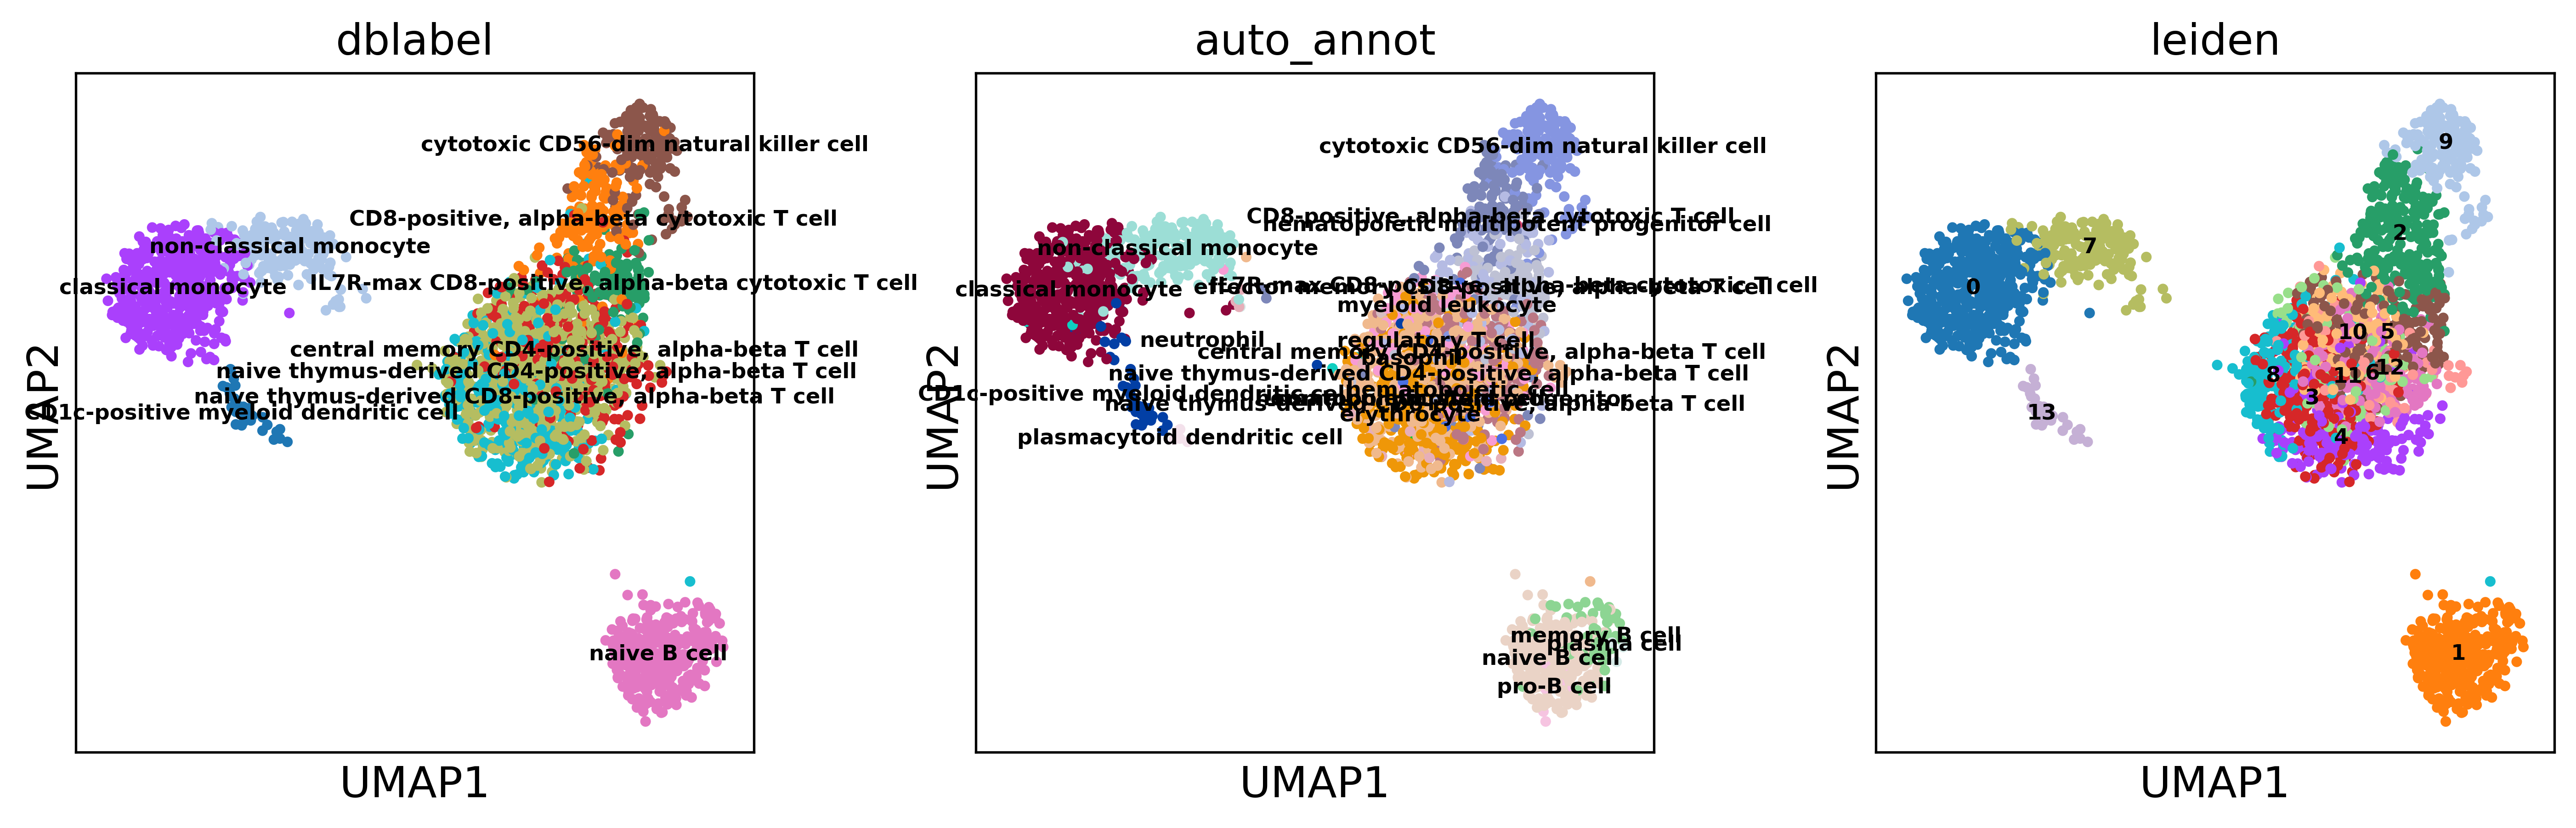

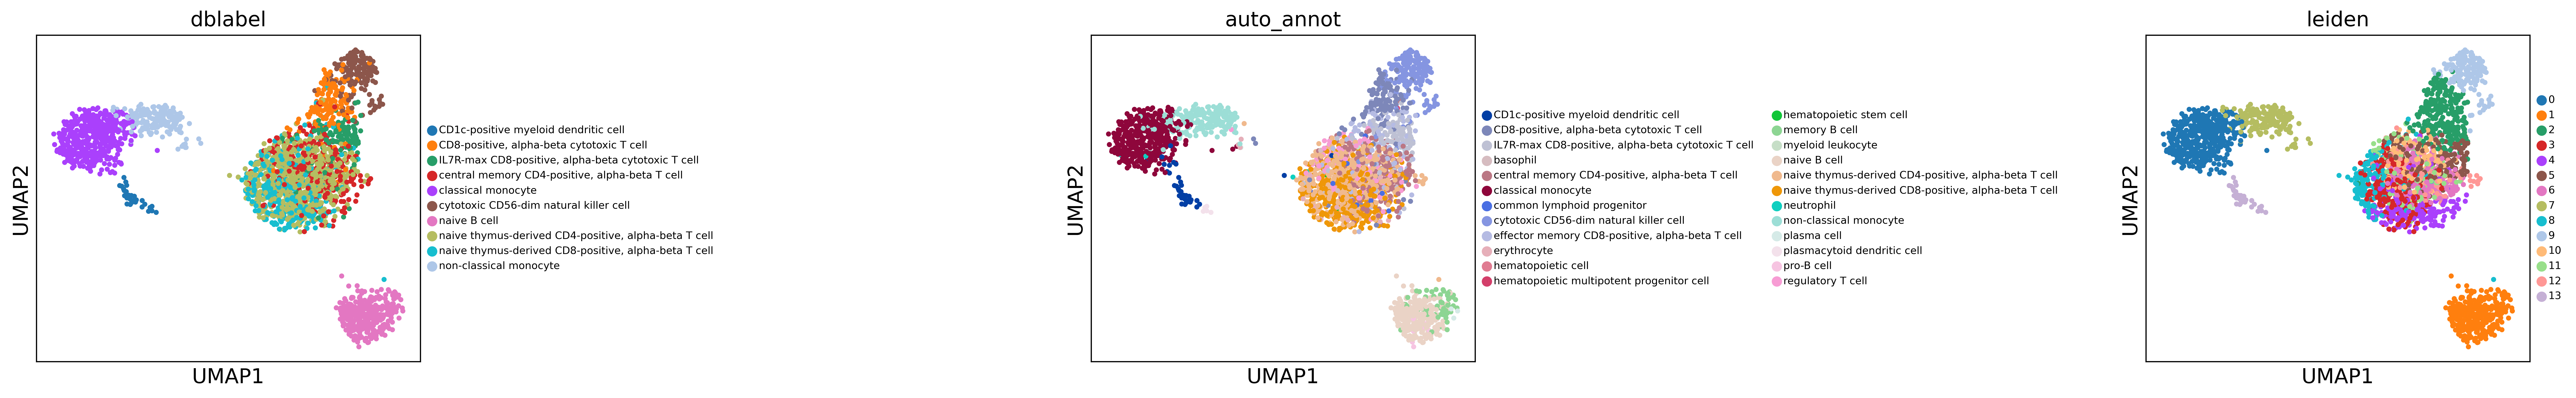

Confusion matrix, without normalization
Normalized confusion matrix


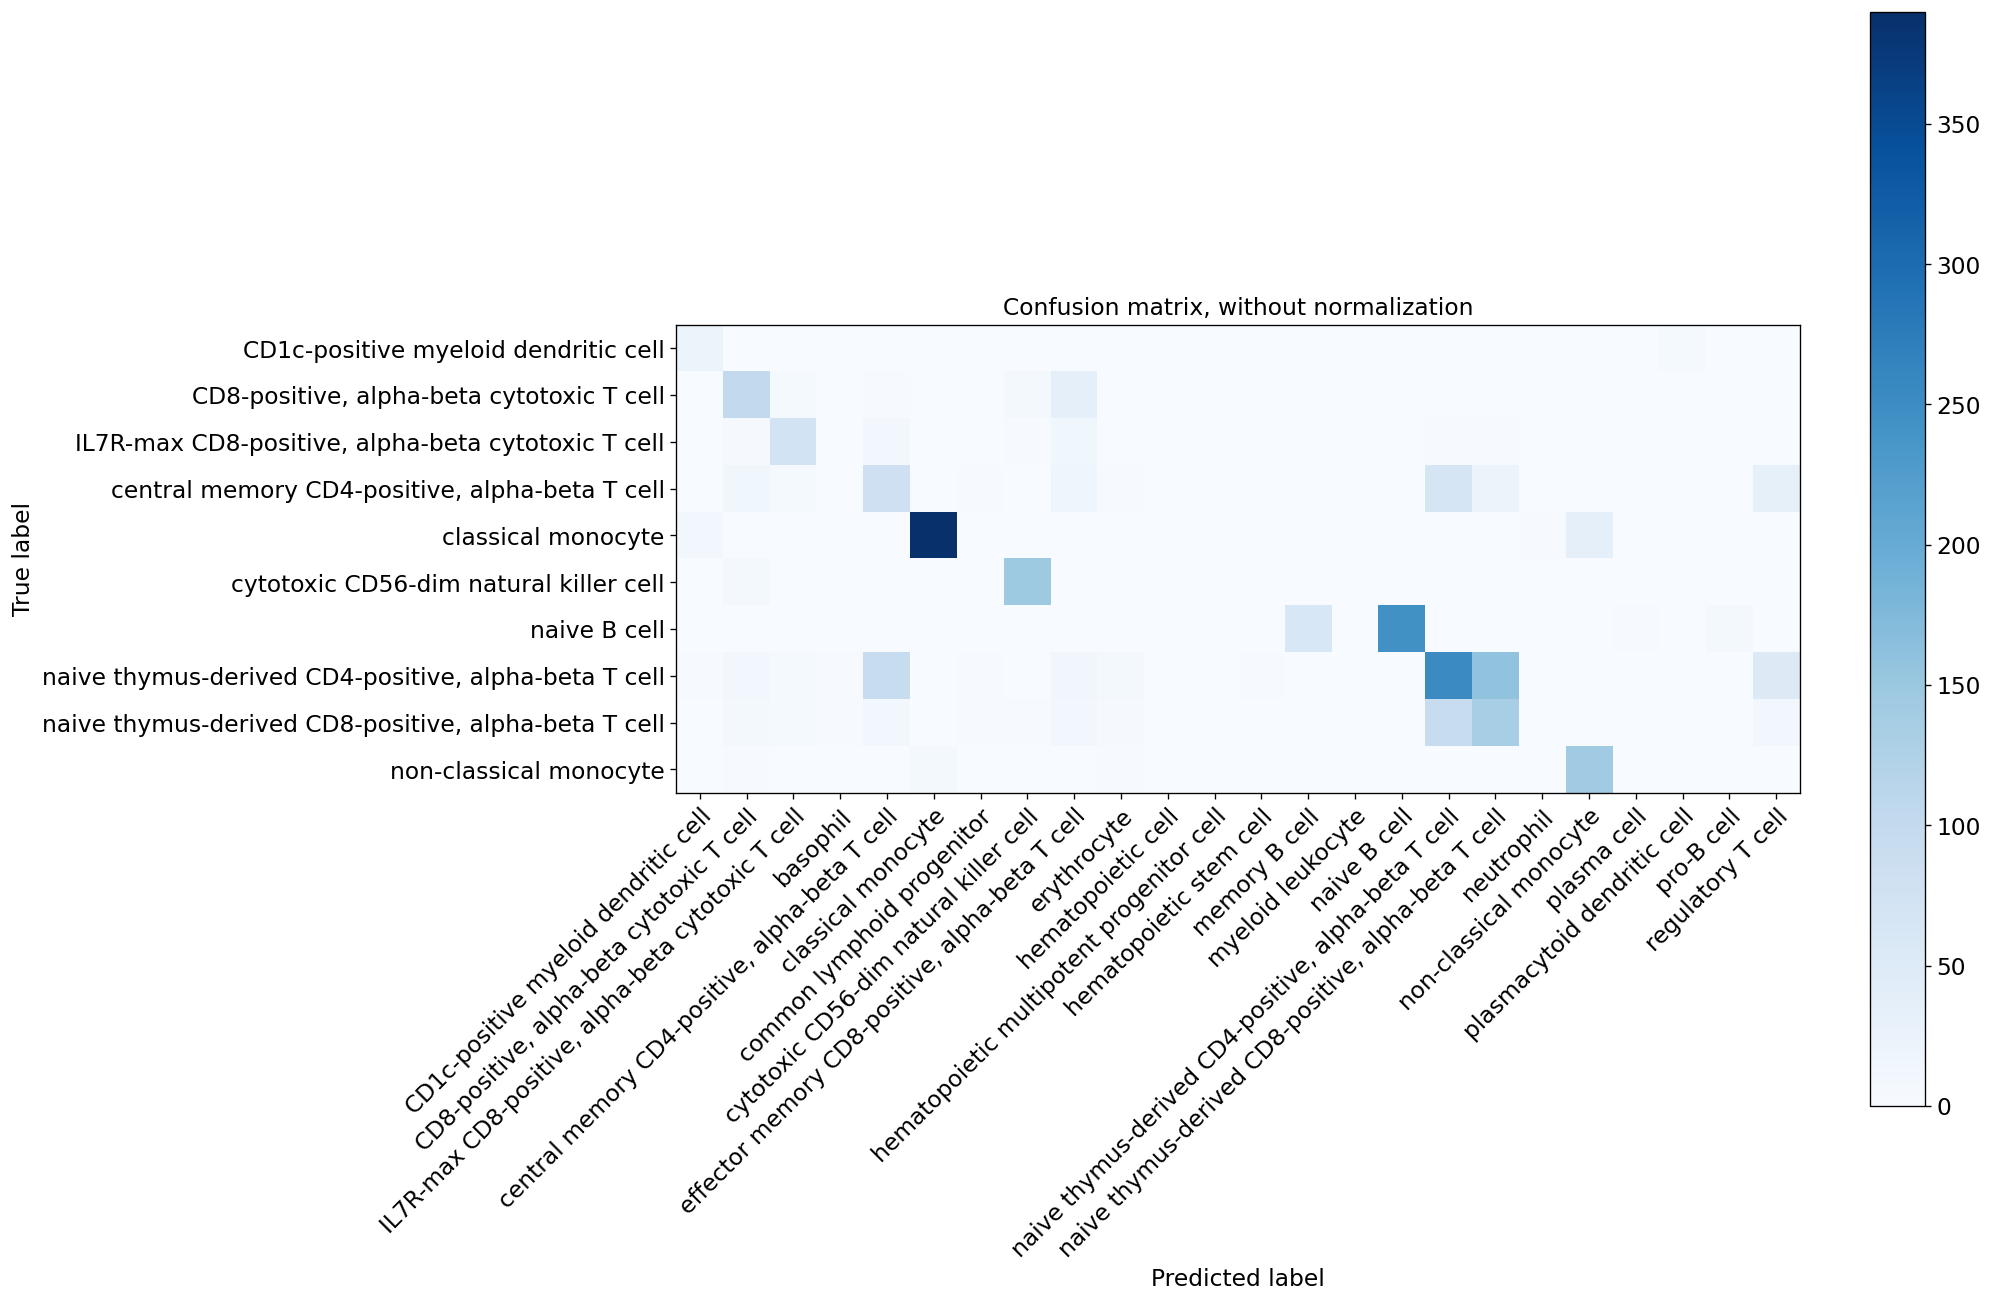

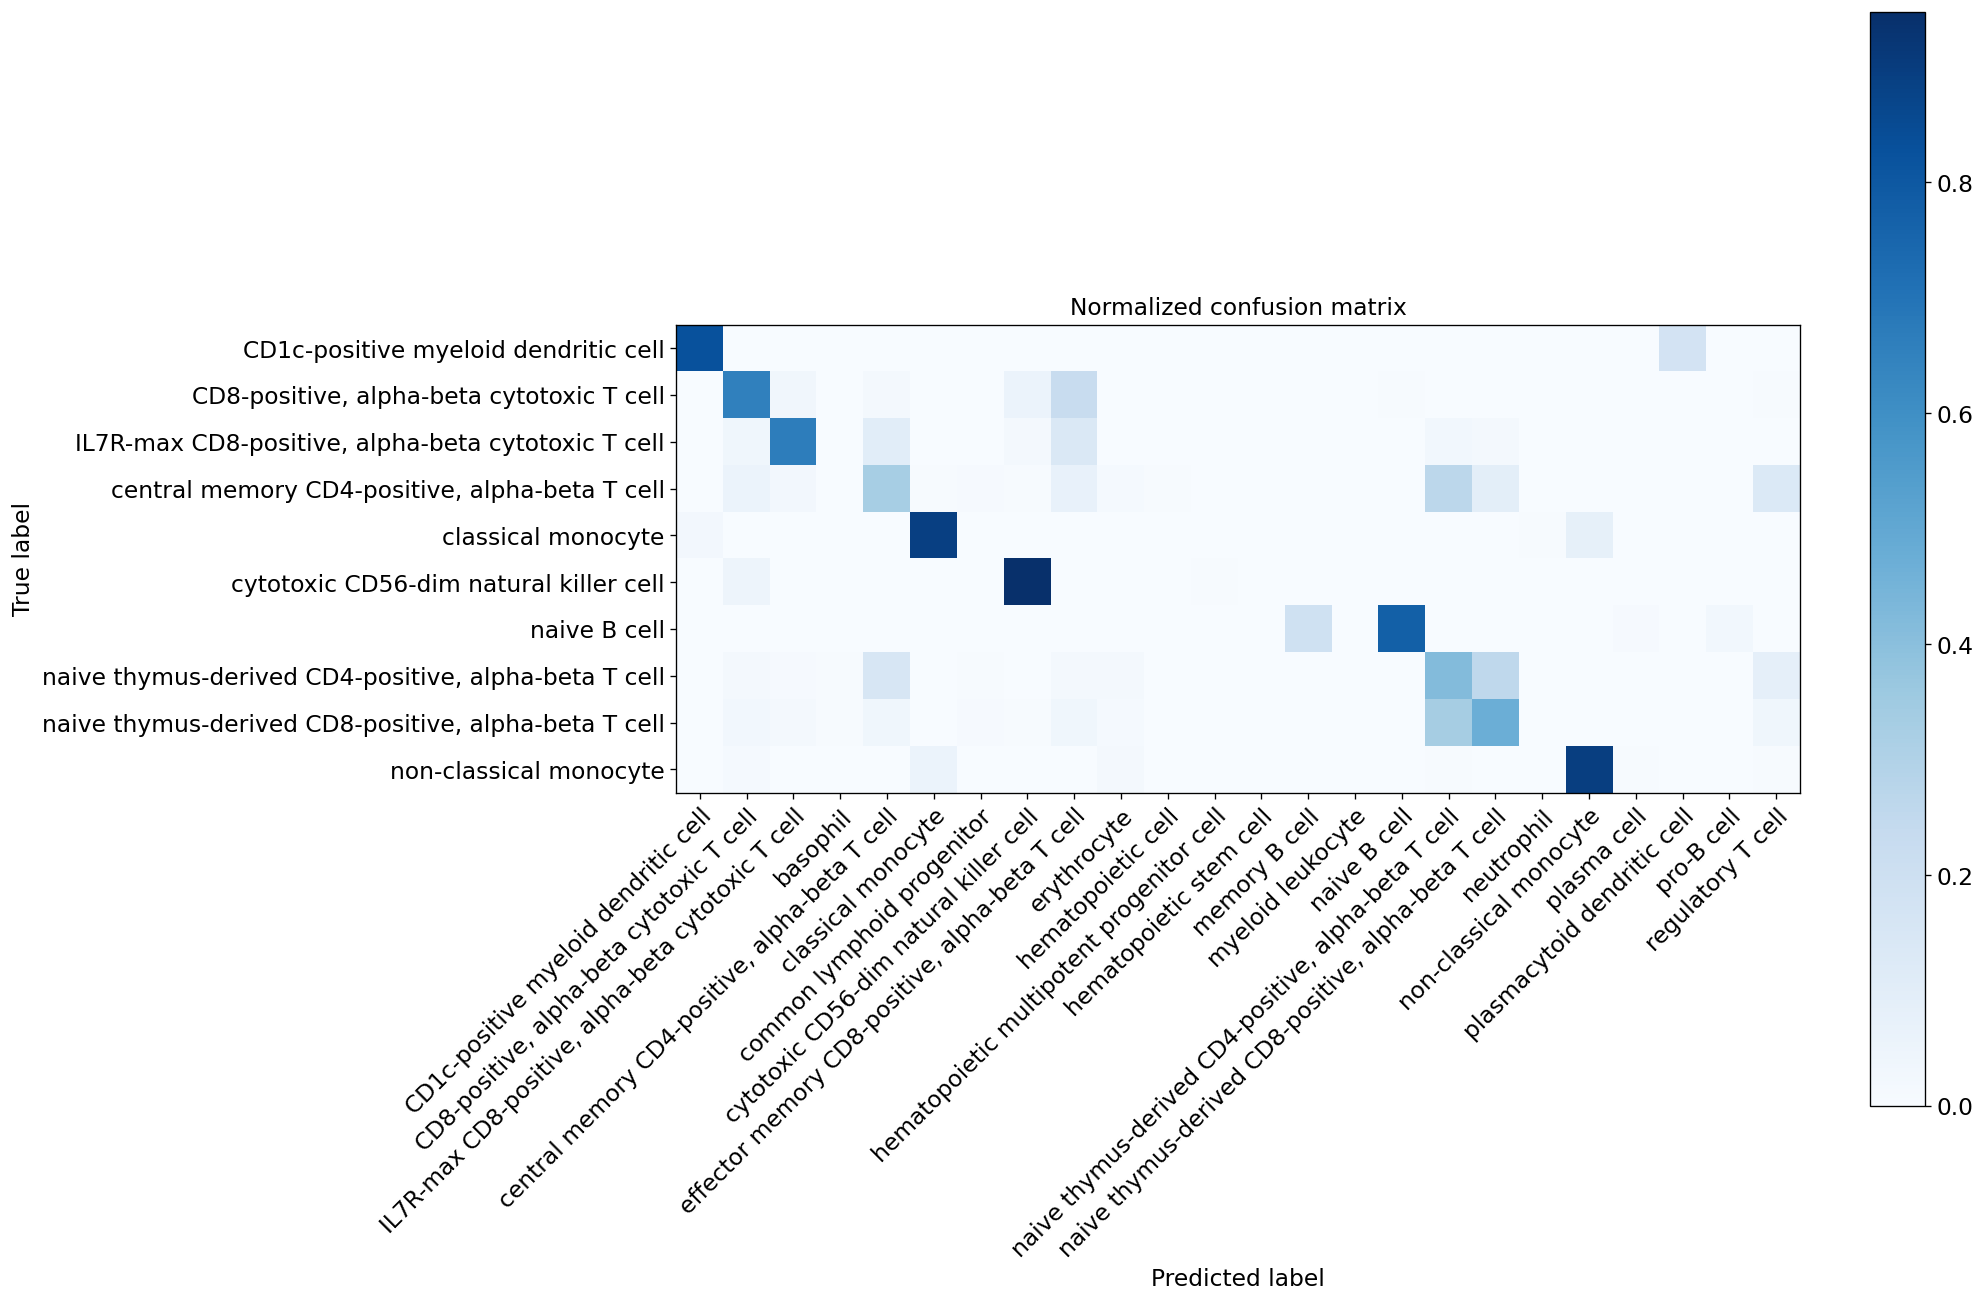

In [34]:
%matplotlib inline
import scanpy as sc
sc.settings.set_figure_params(dpi=90)
bc.tl.auto_annot.report(adata_predicted, celltype, method, analysis_name, False, merge, use_raw, genes_to_use, clustering = 'leiden')

In [72]:
sc.settings.set_figure_params(dpi=80) 
plt.rcParams['svg.fonttype'] = 'none'

sc.pl.umap(adata_predicted, color=[celltype, 'auto_annot', 'leiden'], legend_loc='on data',legend_fontsize=7,  save= '.fig3_ondata.svg')
sc.pl.umap(adata_predicted, color=[celltype, 'auto_annot', 'leiden'],legend_fontsize=7, wspace = 1.4, save = '.fig3.svg')


In [10]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes, celltype,
                          normalize=False,
                          title=None, numbers =False,
                          cmap=plt.cm.Blues, adata_predicted= None, asymmetric_matrix = True): 

    matplotlib.use('Agg')
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if asymmetric_matrix == True:
        class_names =  np.unique(np.concatenate((adata_predicted.obs[celltype], adata_predicted.obs['auto_annot'])))
        class_names_orig = np.unique(adata_predicted.obs[celltype])
        class_names_pred = np.unique(adata_predicted.obs['auto_annot'])
        test_celltypes_ind = np.searchsorted(class_names, class_names_orig)
        train_celltypes_ind = np.searchsorted(class_names, class_names_pred)
        cm=cm[test_celltypes_ind,:][:,train_celltypes_ind]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, shrink = 0.8)
    # We want to show all ticks...
    if asymmetric_matrix == True:
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=class_names_pred, yticklabels=class_names_orig,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')
    else:
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')
        
    ax.grid(False)
    
    ax.set_xlabel('Predicted label', fontsize = 20)
    ax.set_ylabel('True label', fontsize = 20)
    
    #changes to labelsize
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    if numbers == True:
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

In [11]:
import os

In [15]:
# make conf matrices (4)

#for publication plot font size adjustment
sc.settings.set_figure_params(dpi=80) 
plt.rcParams['svg.fonttype'] = 'none'
class_names =  np.unique(np.concatenate((adata_predicted.obs[celltype], adata_predicted.obs['auto_annot'])))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(adata_predicted.obs[celltype], adata_predicted.obs['auto_annot'], title = " ", classes=class_names, celltype=celltype ,numbers = False, adata_predicted = adata_predicted, asymmetric_matrix = True)
plt.savefig(os.path.join('fig3_confusion_matrix_nonnormalised.svg'))

# Plot normalized confusion matrix with numbers
plot_confusion_matrix(adata_predicted.obs[celltype], adata_predicted.obs['auto_annot'], title = " ", classes=class_names,celltype=celltype,  normalize=True, numbers = False, adata_predicted = adata_predicted, asymmetric_matrix = True)
plt.savefig(os.path.join('fig3_confusion_matrix_normalised.svg'))


Confusion matrix, without normalization
Normalized confusion matrix


# let's use a threshold

In [39]:
analysis_name = 'auto_annot_pubimage_threshold' # The analysis name will be used to name the output files

In [40]:
adata_predicted_threshold = bc.tl.auto_annot.adata_pred_prob(classifier = classifier, scaler = scaler, adata_pred = adata_test_corrected, adata_orig = adata_test_orig, threshold = 0.7)

In [41]:
#adata_predicted_threshold.write('./adata_predicted_threshold_23062020.h5ad')

... storing 'auto_annot' as categorical


In [12]:
#adata_predicted_threshold = sc.read('./adata_predicted_threshold_23062020.h5ad')

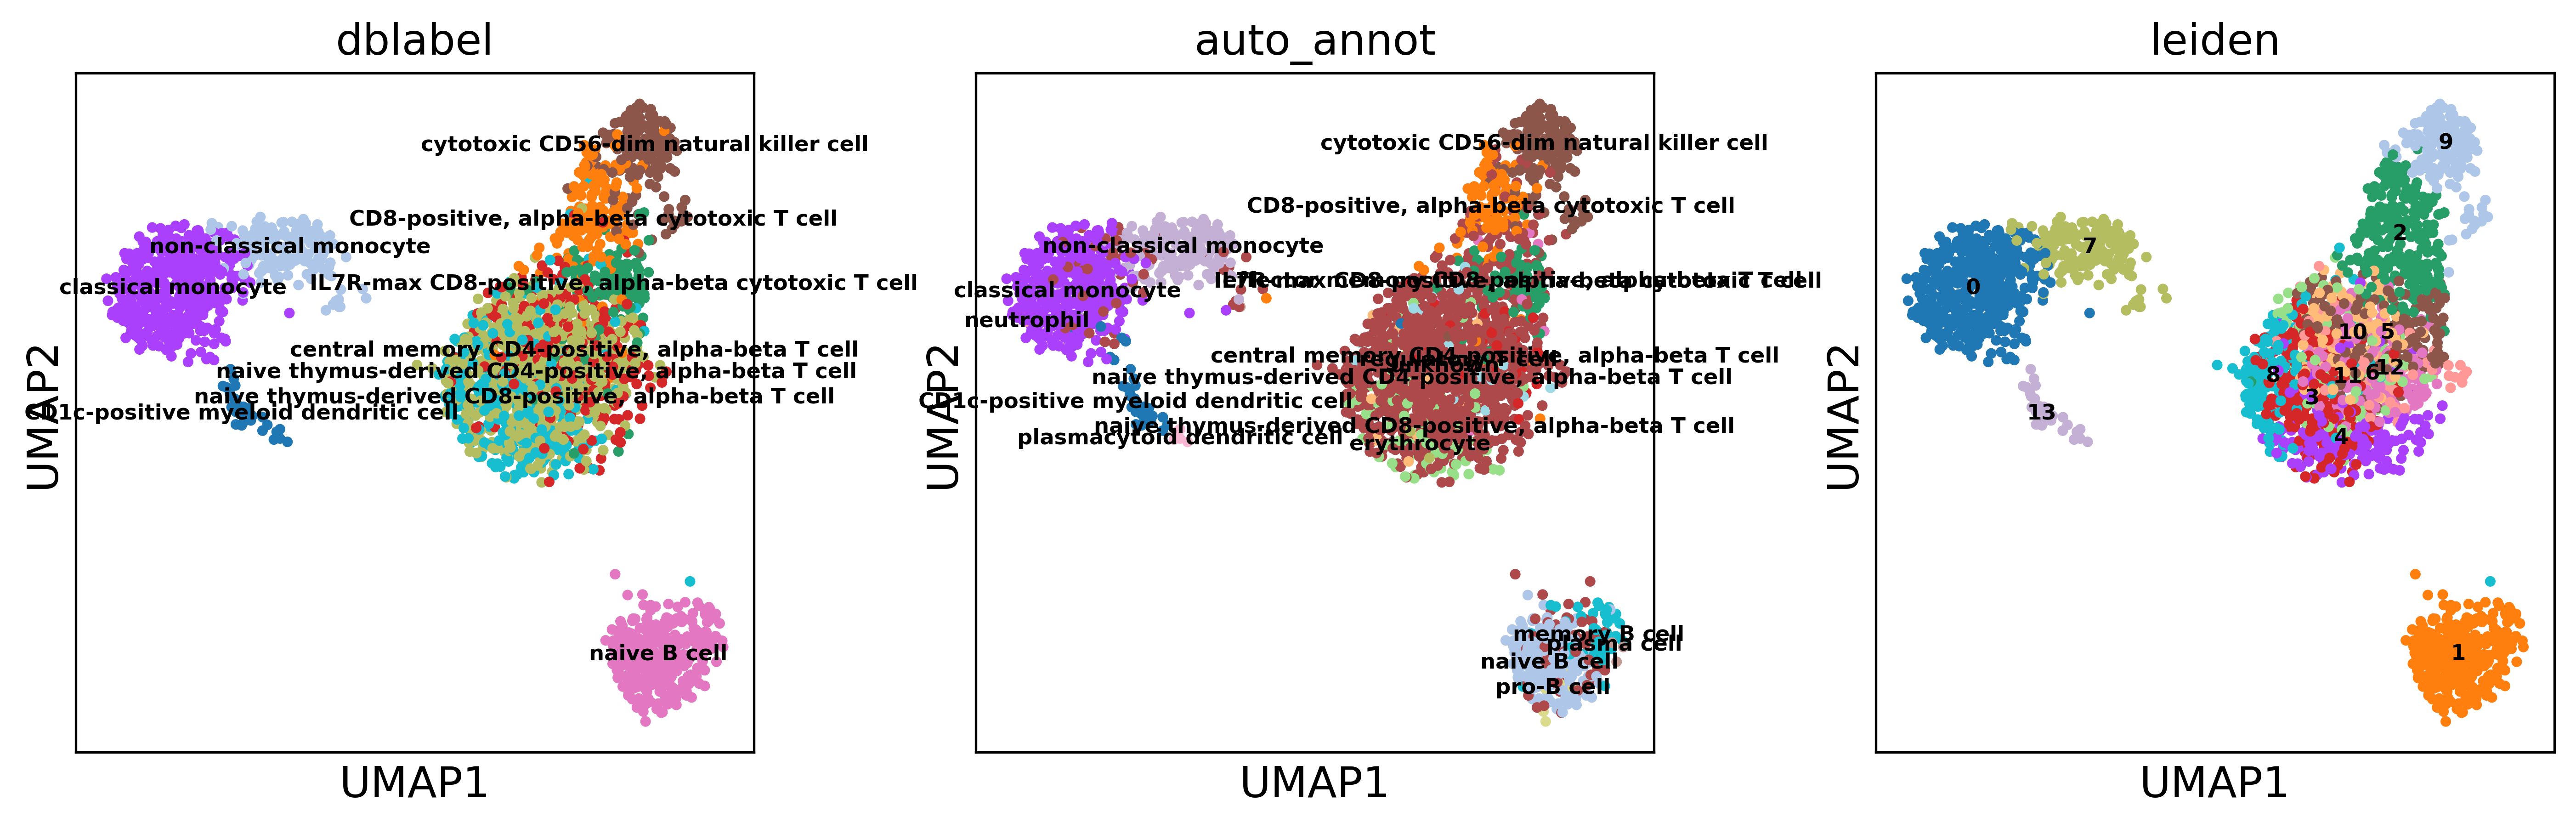

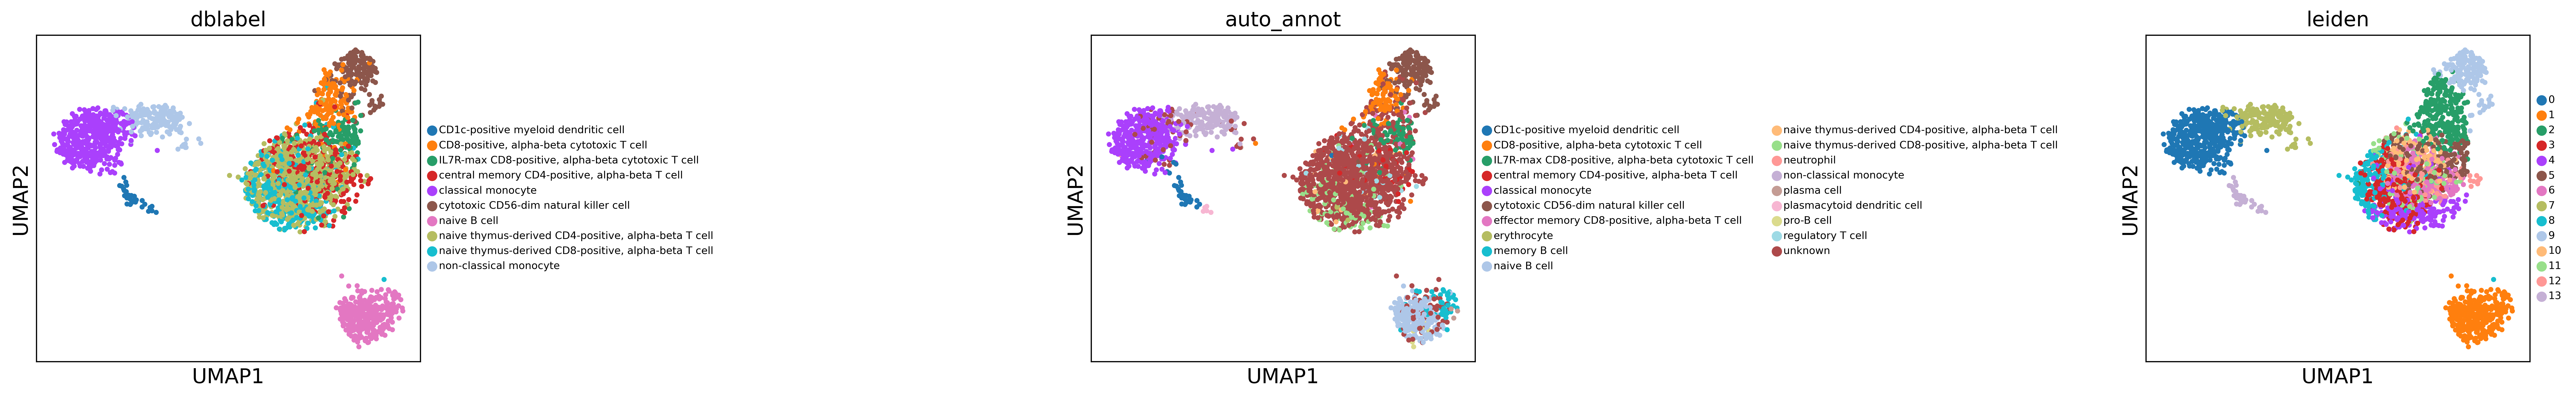

Confusion matrix, without normalization
Normalized confusion matrix


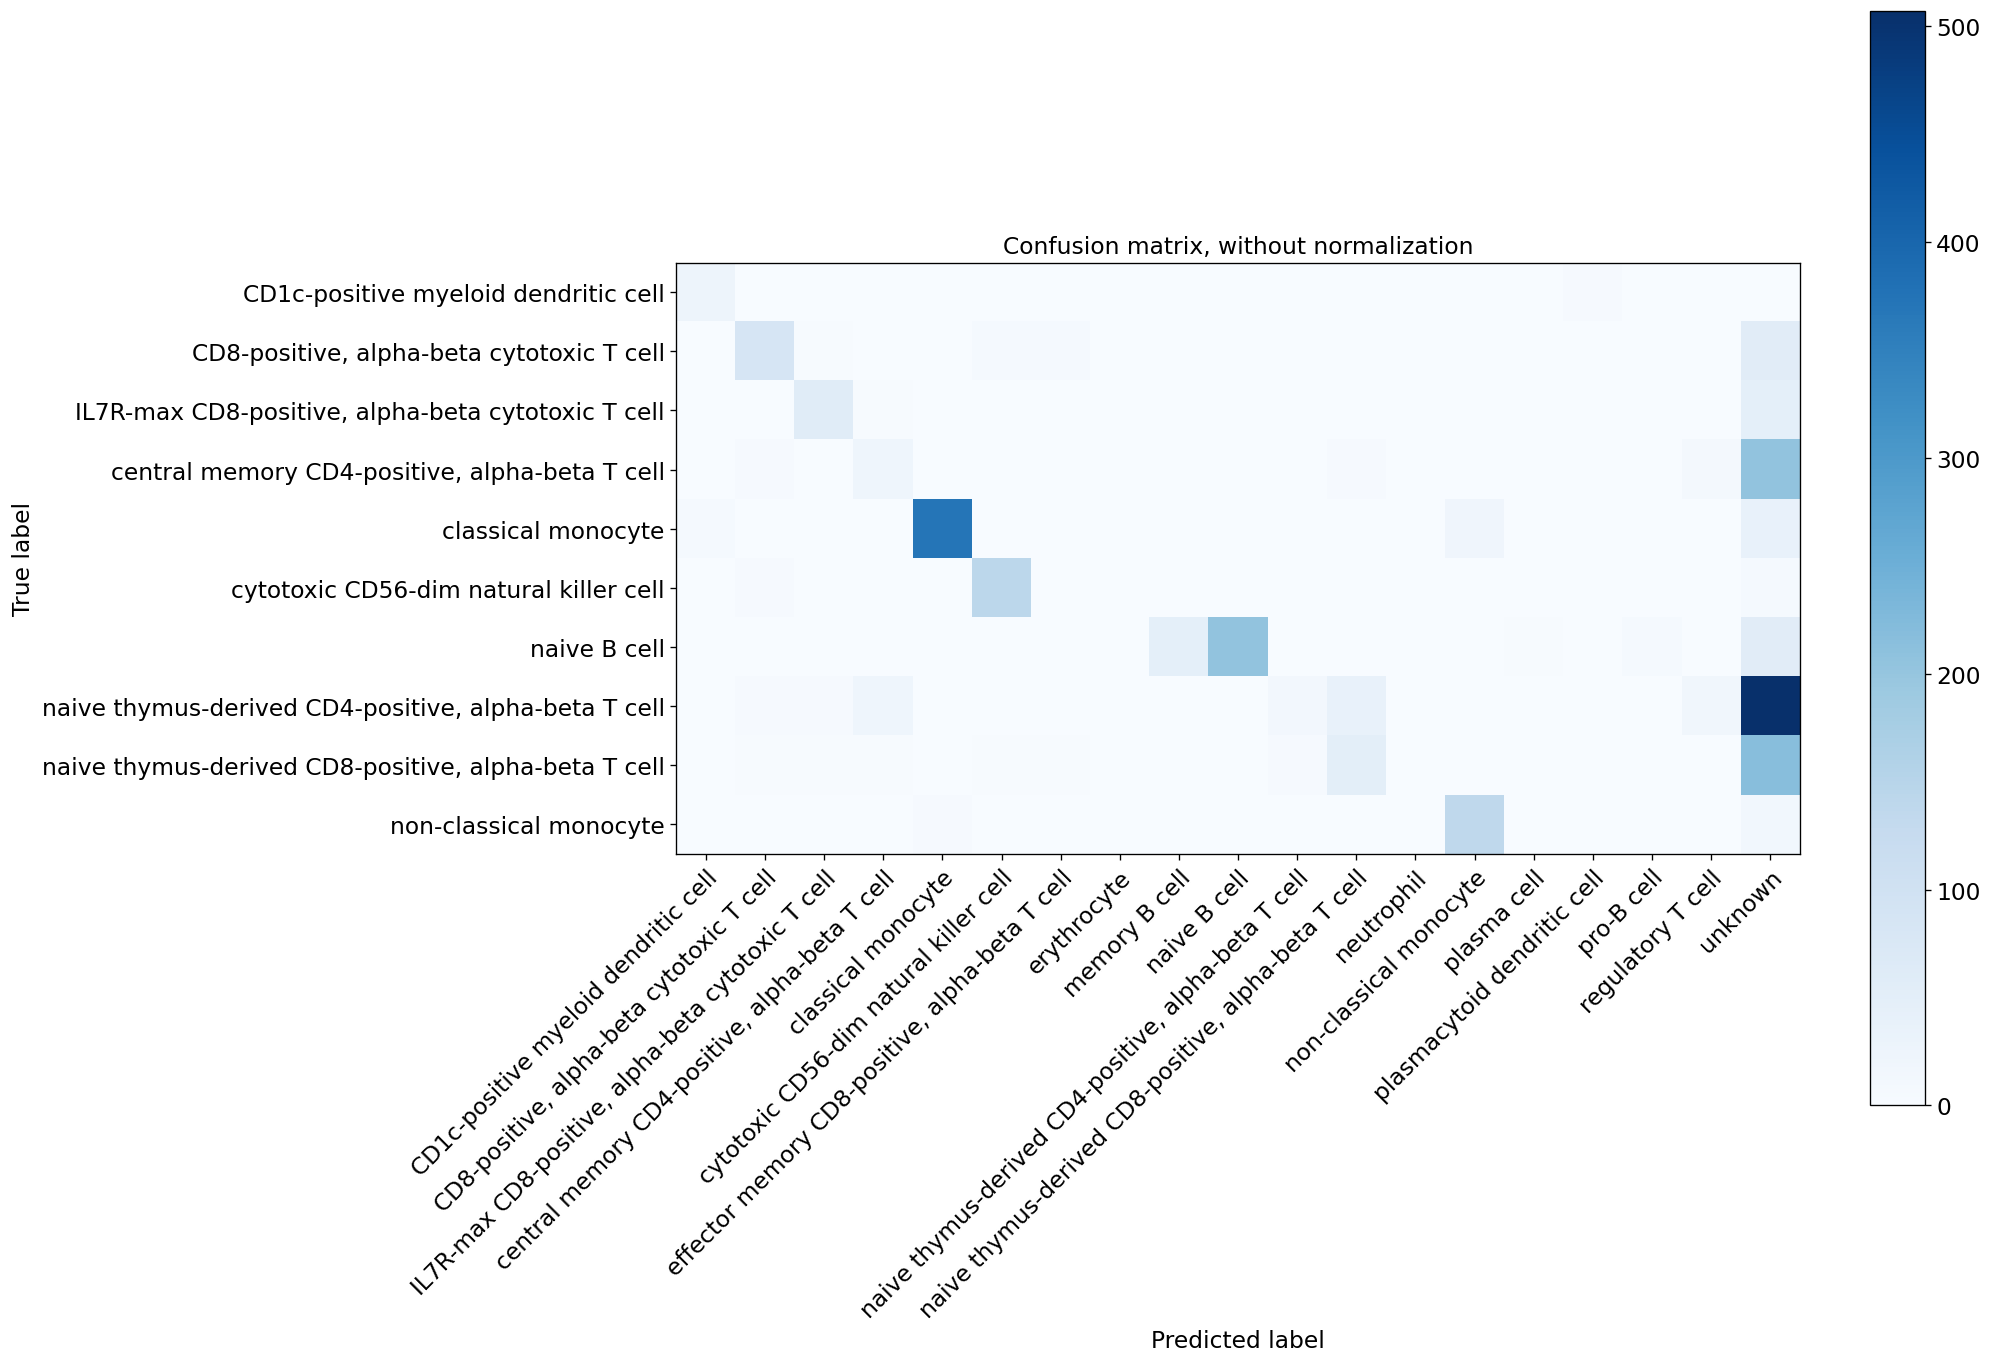

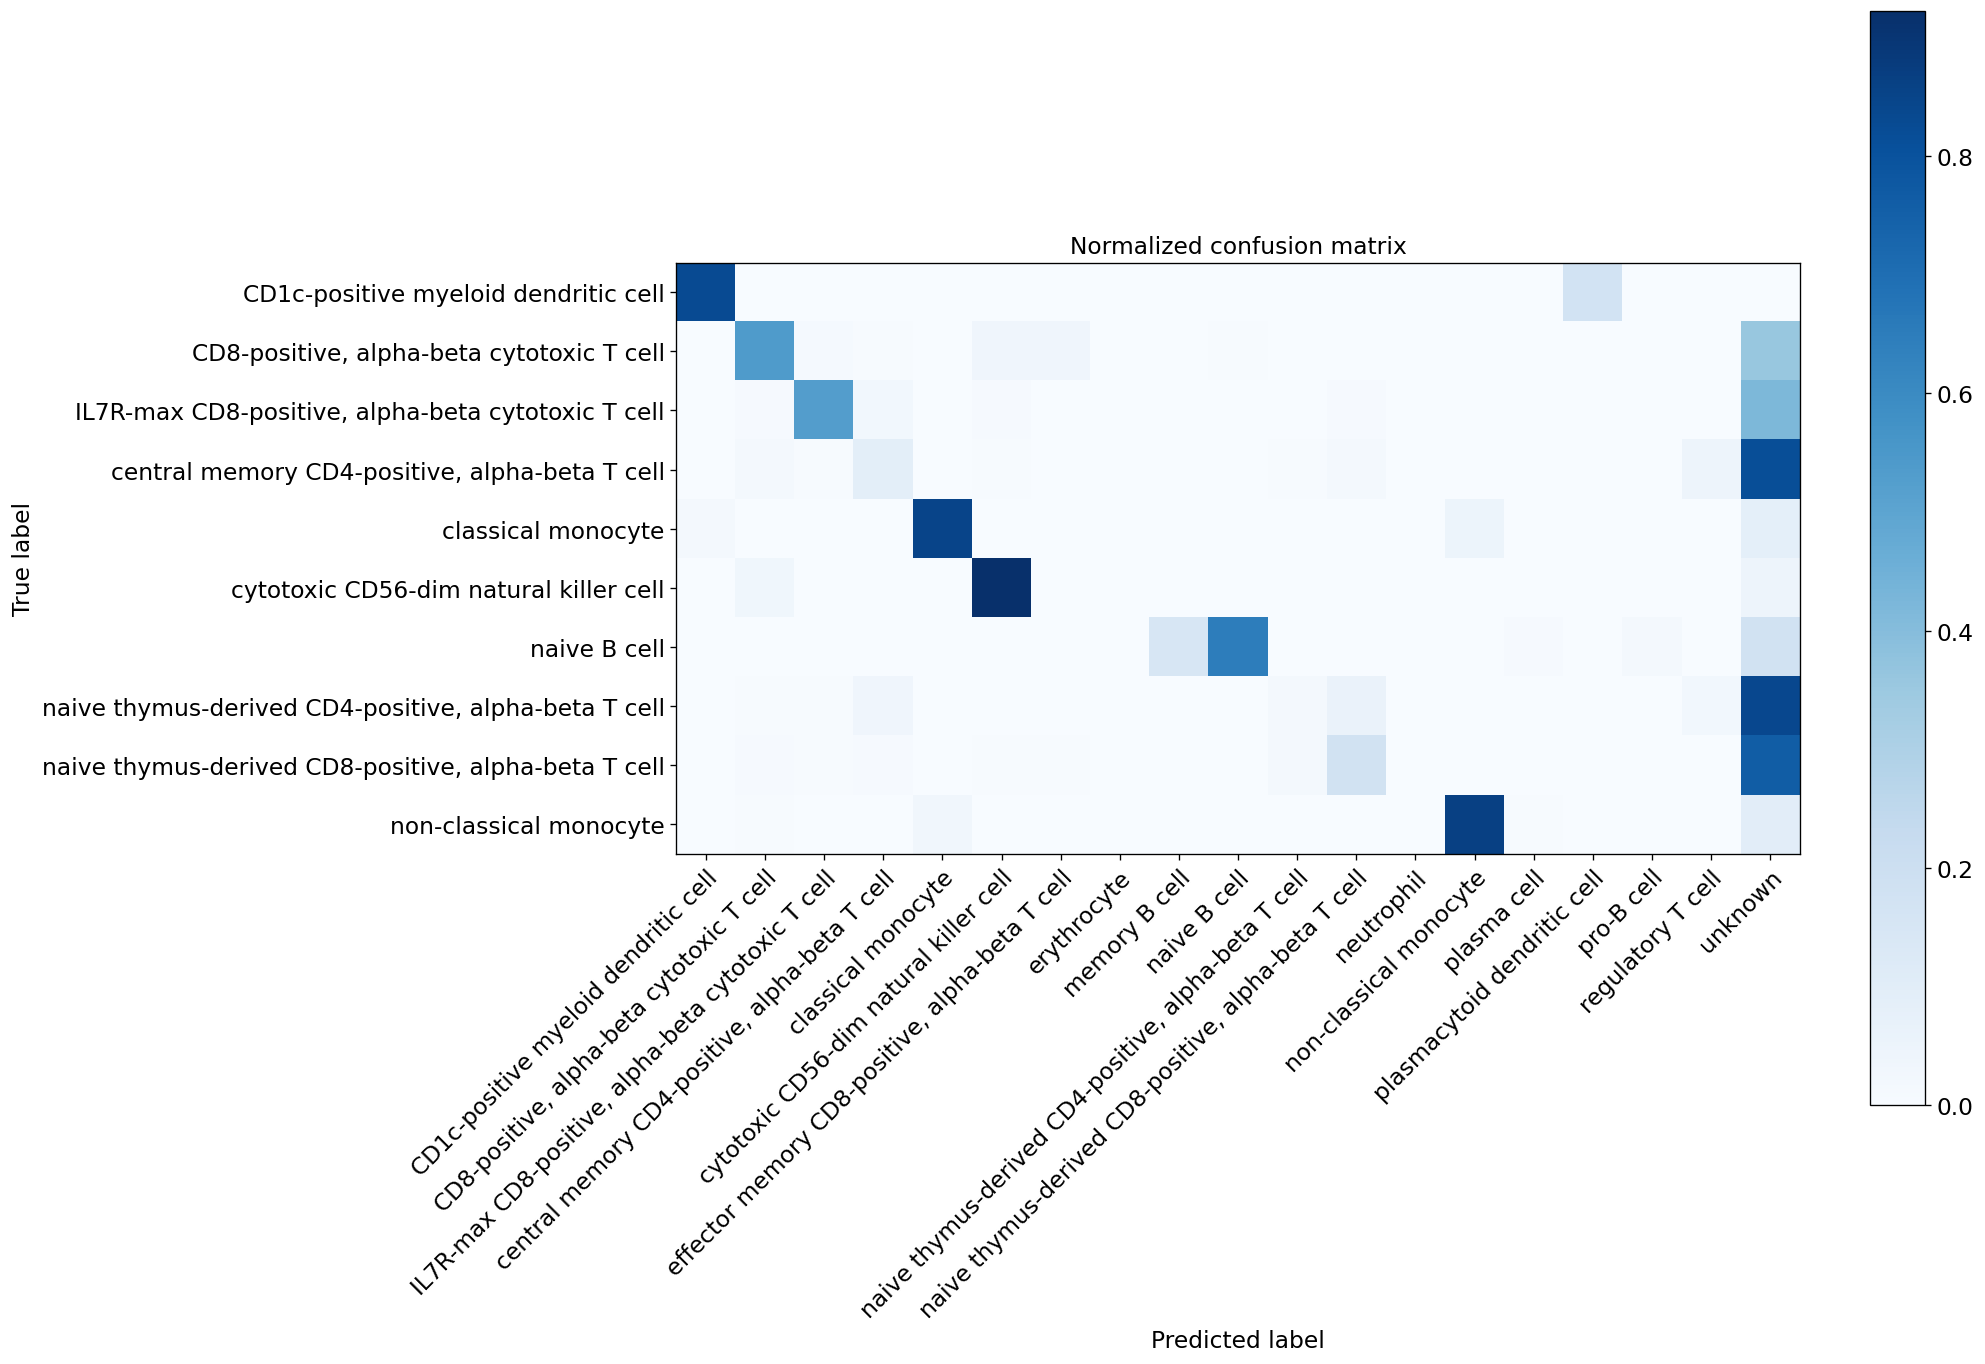

In [42]:
%matplotlib inline



bc.tl.auto_annot.report(adata_predicted_threshold, celltype, method, analysis_name, False, merge, use_raw, genes_to_use, clustering = 'leiden')

In [71]:
#sc.settings.set_figure_params(dpi=240)

sc.settings.set_figure_params(dpi=80) 
plt.rcParams['svg.fonttype'] = 'none'

sc.pl.umap(adata_predicted_threshold, color=[celltype, 'auto_annot', 'leiden'], legend_loc='on data',legend_fontsize=7,  save= '.fig3_threshold_ondata.svg')
sc.pl.umap(adata_predicted_threshold, color=[celltype, 'auto_annot', 'leiden'],legend_fontsize=7, wspace = 1.4, save = '.fig3_threshold.svg')


In [14]:
# make conf matrices (4)
sc.settings.set_figure_params(dpi=80) 
plt.rcParams['svg.fonttype'] = 'none'
class_names =  np.unique(np.concatenate((adata_predicted_threshold.obs[celltype], adata_predicted_threshold.obs['auto_annot'])))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(adata_predicted_threshold.obs[celltype], adata_predicted_threshold.obs['auto_annot'], title = " ", classes=class_names, celltype=celltype ,numbers = False, adata_predicted = adata_predicted_threshold, asymmetric_matrix = True)
plt.savefig(os.path.join('fig3_confusion_matrix_threshold_nonnormalised.svg'))

# Plot normalized confusion matrix with numbers
plot_confusion_matrix(adata_predicted_threshold.obs[celltype], adata_predicted_threshold.obs['auto_annot'], title = " ", classes=class_names,celltype=celltype,  normalize=True, numbers = False, adata_predicted = adata_predicted_threshold, asymmetric_matrix = True)
plt.savefig(os.path.join('fig3_confusion_matrix_threshold_normalised.svg'))


Confusion matrix, without normalization
Normalized confusion matrix


# let's check if the differences in annotation make sense

In [45]:
 ## PROVIDED WITH BESCA
root_path = os.getcwd()

gmt_file_IMM= os.path.split(root_path)[0] + '/../../besca/besca/datasets/genesets/HumanCD45p_scseqCMs6.gmt'
bc.tl.sig.combined_signature_score(adata_predicted, gmt_file_IMM)


In [46]:
adata_predicted.var_names

Index(['ISG15', 'TNFRSF4', 'CPSF3L', 'MRPL20', 'ATAD3C', 'C1orf86', 'RER1',
       'TPRG1L', 'TNFRSF25', 'TNFRSF9',
       ...
       'DSCR3', 'BRWD1', 'BACE2', 'SIK1', 'C21orf33', 'ICOSLG', 'SUMO3',
       'SLC19A1', 'S100B', 'PRMT2'],
      dtype='object', length=1719)

In [47]:
scores = [x for x in adata_predicted.obs.columns if 'CD45' in x]
scores

['score_HumanCD45p_scseqCMs6_ActB_scanpy',
 'score_HumanCD45p_scseqCMs6_Activation_scanpy',
 'score_HumanCD45p_scseqCMs6_Basophil_scanpy',
 'score_HumanCD45p_scseqCMs6_Bcells_scanpy',
 'score_HumanCD45p_scseqCMs6_CCG1S_scanpy',
 'score_HumanCD45p_scseqCMs6_CCG2M_scanpy',
 'score_HumanCD45p_scseqCMs6_Cafs_scanpy',
 'score_HumanCD45p_scseqCMs6_Cellcycle_scanpy',
 'score_HumanCD45p_scseqCMs6_Checkpoint_scanpy',
 'score_HumanCD45p_scseqCMs6_Cyto_scanpy',
 'score_HumanCD45p_scseqCMs6_Cytotox_scanpy',
 'score_HumanCD45p_scseqCMs6_DCR_scanpy',
 'score_HumanCD45p_scseqCMs6_DCrec_scanpy',
 'score_HumanCD45p_scseqCMs6_DCs_scanpy',
 'score_HumanCD45p_scseqCMs6_Eff_scanpy',
 'score_HumanCD45p_scseqCMs6_Endo_scanpy',
 'score_HumanCD45p_scseqCMs6_Endot_scanpy',
 'score_HumanCD45p_scseqCMs6_Endothelial_scanpy',
 'score_HumanCD45p_scseqCMs6_Eosinophil_scanpy',
 'score_HumanCD45p_scseqCMs6_Epith_scanpy',
 'score_HumanCD45p_scseqCMs6_ExhB_scanpy',
 'score_HumanCD45p_scseqCMs6_Granulo_scanpy',
 'score_Hu

Indeed it seems like the classification of B cells is an improvement, whereas the varieties of T cells pose difficulties.

In [73]:
sc.settings.set_figure_params(dpi=80) 
plt.rcParams['svg.fonttype'] = 'none'

sc.pl.umap(adata_predicted, color= ["score_HumanCD45p_scseqCMs6_MemB_scanpy", "score_HumanCD45p_scseqCMs6_NaiveB_scanpy","CD4", "CD8A", "IL7R", "NKG7"], ncols = 2, wspace = 0.4, color_map = 'viridis',save= '.fig3_markers.svg')

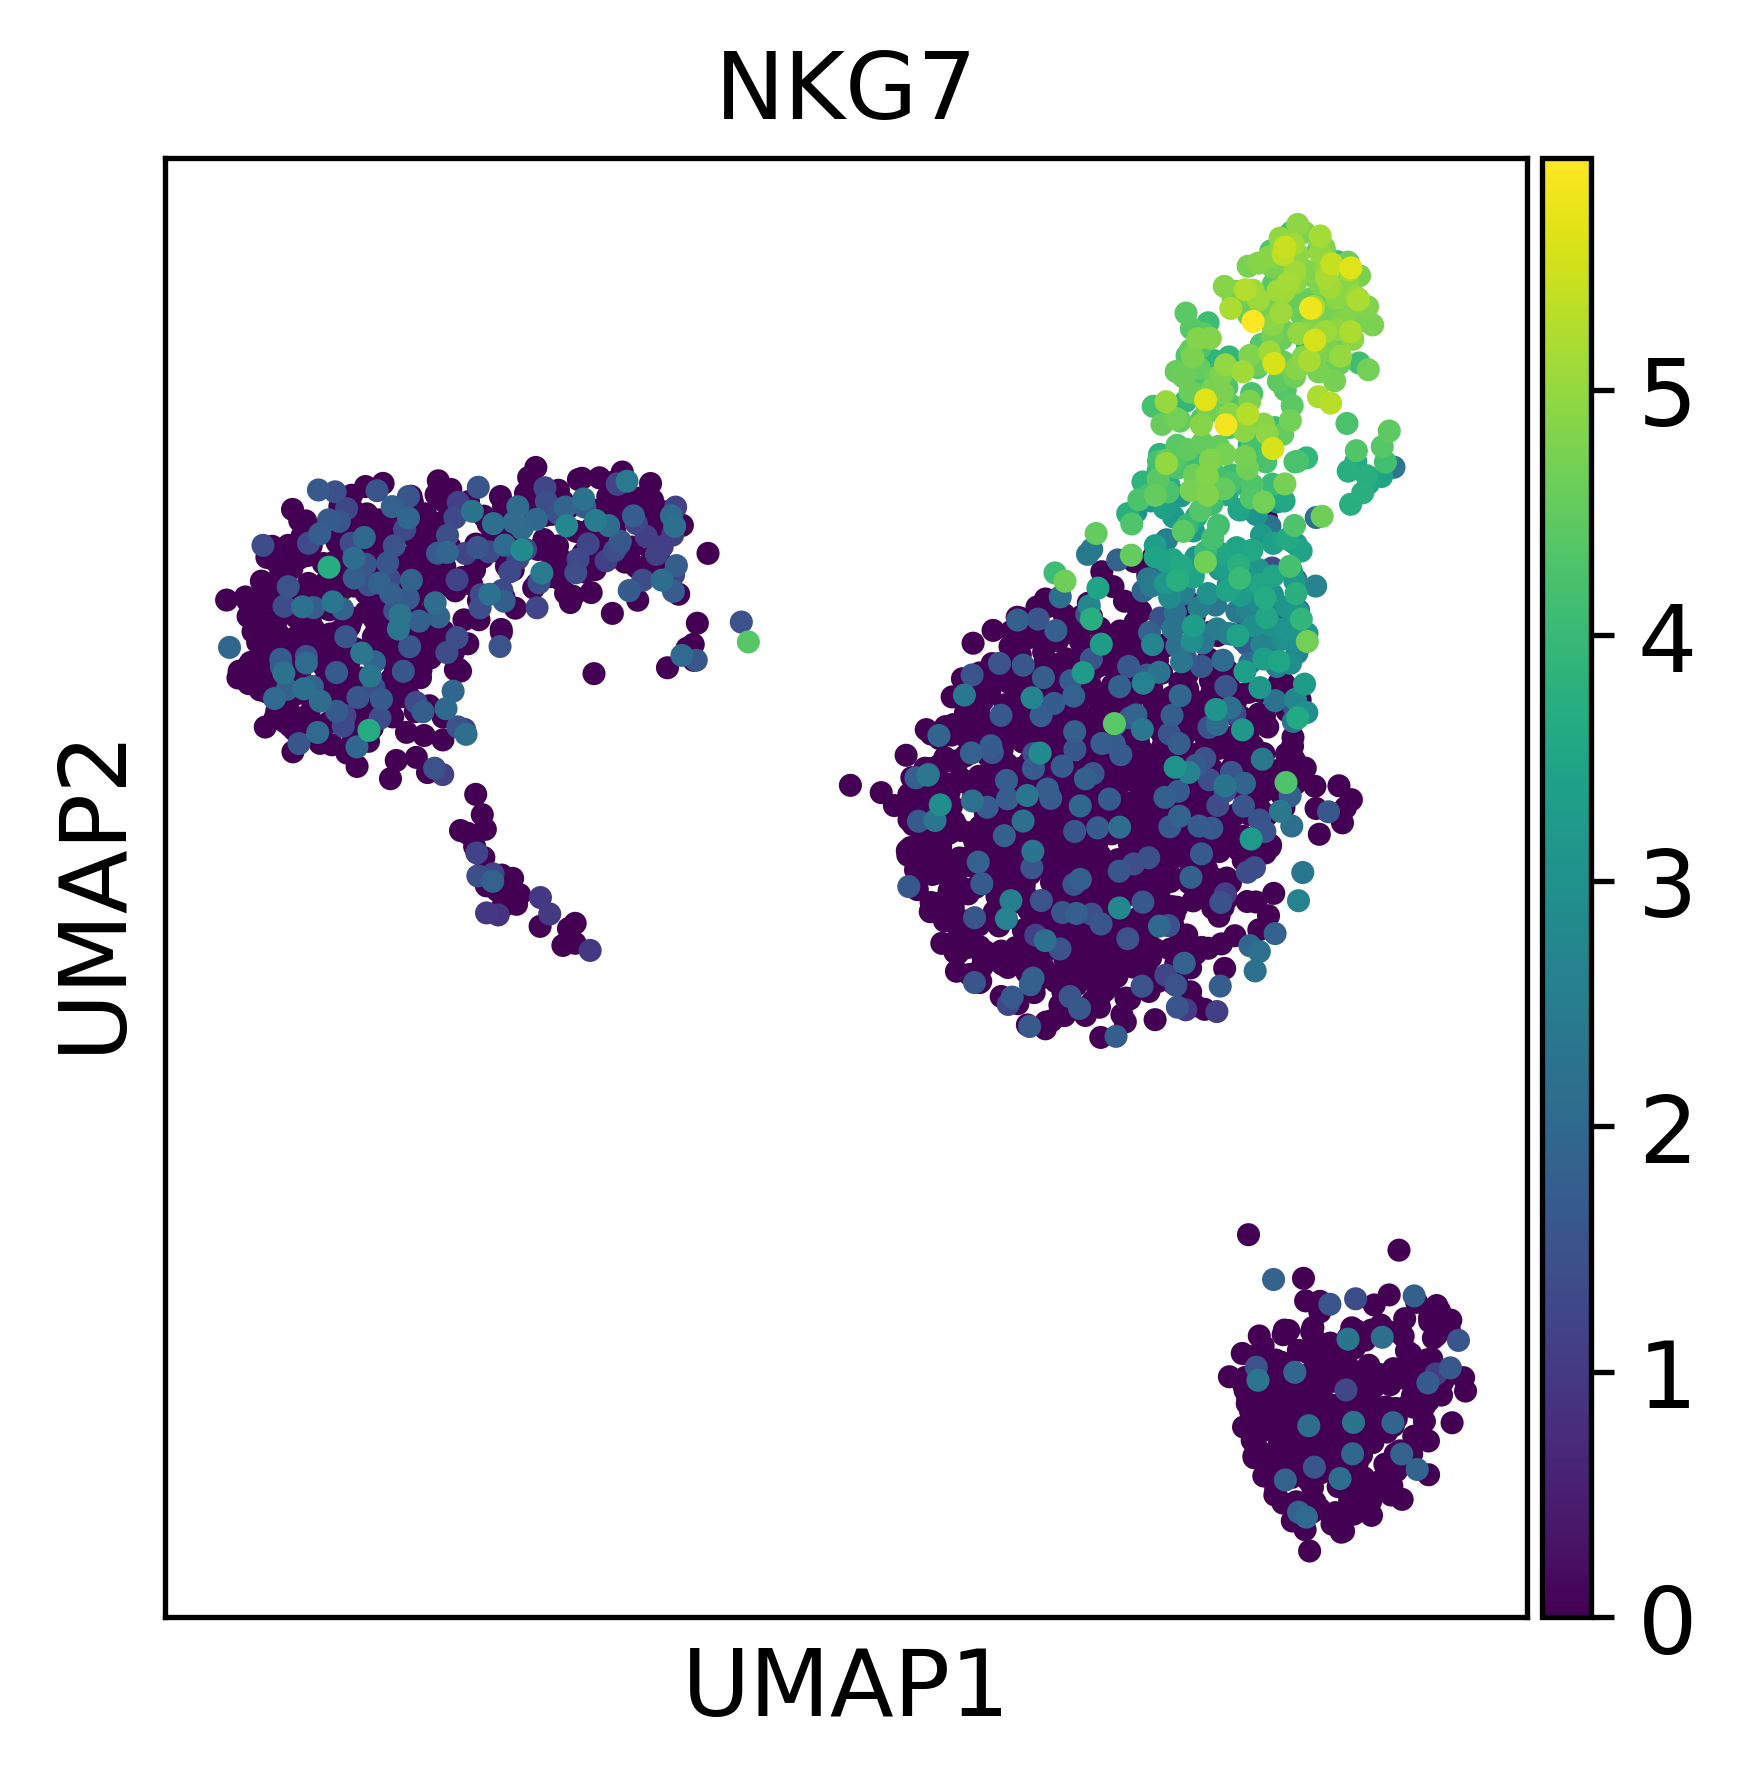

In [49]:

sc.pl.umap(adata_predicted, color= ["NKG7"], ncols = 2, wspace = 0.4, color_map = 'viridis')